In [1]:
import cv2
import numpy as np
from scipy.ndimage import convolve
from skimage.morphology import disk
import matplotlib.pyplot as plt

In [2]:
def gauss_ker(k, sig):
    x = np.linspace(-(k//2), (k//2), k)
    gx, gy = np.meshgrid(x, x)
    kernel = np.exp(-1*(gx**2 + gy**2)/(2*(sig**2)))
    return kernel
def shadowRem(imflash, imambient):
#     linflash = 0.299*imflash[:,:,0] + 0.587*imflash[:,:,1] + 0.114*imflash[:,:,2]
#     linambient = 0.299*imambient[:,:,0] + 0.587*imambient[:,:,1] + 0.114*imambient[:,:,2]
    
    linflash = cv2.cvtColor(imflash, cv2.COLOR_BGR2GRAY)/255.0
    linambient = cv2.cvtColor(imambient, cv2.COLOR_BGR2GRAY)/255.0
    mask = linflash - linambient
    
    flag = np.zeros((mask.shape), np.uint8)
    thr1 = -0.05
    thr2 = -0.2 
    flag[(mask > thr2) & (mask < thr1)] = 1
    flag[(mask > 0.65) & (mask < 0.7)] = 1
    rang = 0.95*(np.max(linflash) - np.min(linflash))
    flag[linflash > rang] = 1

    se1 = disk(2)
    se2 = disk(6)
    se3 = disk(4)
    plt.figure(figsize=(15,5))
    flag = cv2.erode(flag, se1, iterations = 1)
    plt.subplot(131)
    plt.imshow(flag, cmap='gray')
    maskff = np.zeros((flag.shape[0]+2, flag.shape[1]+2), np.uint8)
    plt.subplot(132)
    plt.imshow(maskff, cmap='gray')
    cv2.floodFill(flag,maskff, (0,0), 1)
#     flag = maskff-flag
    plt.subplot(133)
    plt.imshow(flag, cmap='gray')
    maskff = cv2.dilate(maskff, se2,  iterations = 1)
    maskff = cv2.erode(maskff, se3, iterations = 1)
    maskff = maskff.astype('double')
    k = 3
    sig = 3
    kernel = gauss_ker(3, 3)
    maskff = cv2.filter2D(maskff, -1, kernel)
    
    fig = plt.figure(figsize=[8, 8])
    plt.imshow(linflash, cmap='gray')
    
    return maskff
# flash_image = cv2.imread('potsdetail_00_flash.tif')
# noflash_image = cv2.imread('potsdetail_01_noflash.tif')
# mask = shadowRem(flash_image,noflash_image)

In [3]:

# fig = plt.figure(figsize=[8, 8])
# plt.imshow(mask, cmap='gray')
# plt.title('ambient image')


Going through color channels:   0%|          | 0/3 [02:03<?, ?it/s]


KeyboardInterrupt: 

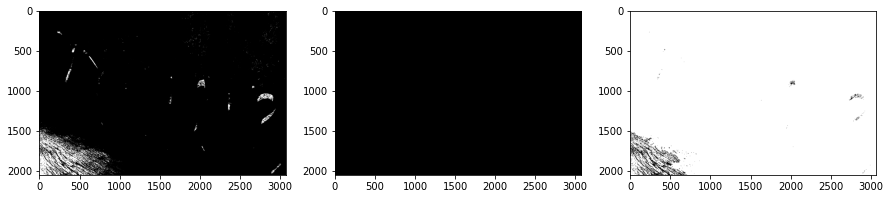

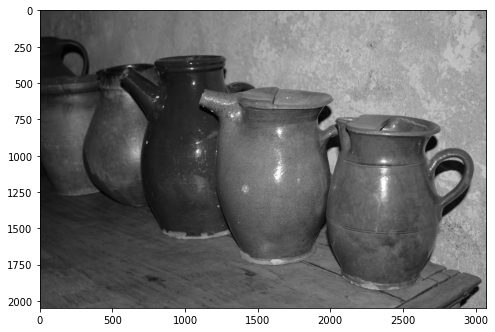

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

def normalize(array):
    """Min-Max Normalization of the array
    :param array: 2-D input image array
    :output : returns normalized arrays
    """
    return (array - np.min(array))/(np.max(array)-np.min(array))

def bilateral(filename,input_image, sigma_spatial, sigma_intensity):
    """
    Performs standard bilateral filtering of an input image. If padding is desired,
    img_in should be padded prior to calling
    inputs:- input_image       (ndarray) input image
           - sigma_spatial      (float)   spatial gaussian standard deviation
           - sigma_intensity      (float)   value gaussian standard. deviation
    outputs:-result      (ndarray) output bilateral-filtered image
    """

    # make a simple Gaussian function taking the squared radius
    gaussian = lambda r2, sigma: np.exp(-0.5*r2/sigma**2 )
    #print(input_image.shape)
    input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)

    # define the window width to be the 2 time the spatial std. dev. to
    # be sure that most of the spatial kernel is actually captured
    win_width = int(3*sigma_spatial +1)
    wgt_sum = np.zeros_like(input_image).astype(np.float64)
    result  = np.zeros_like(input_image).astype(np.float64)
    out= np.zeros_like(input_image).astype(np.float64)

    for i in tqdm(range(input_image.shape[-1]),desc="Going through color channels"):
        norm_image = normalize(input_image[:,:,i])
        for shft_x in range(-win_width,win_width+1):
            for shft_y in range(-win_width,win_width+1):
                # compute the spatial contribution
                spatial = gaussian(shft_x**2+shft_y**2, sigma_spatial )

                # shift by the offsets to get image window
                window = np.roll(norm_image, [shft_y, shft_x], axis=[0,1])

                # compute the intensity contribution
                combined_filter = spatial*gaussian( (window-norm_image)**2, sigma_intensity )

                # result stores the mult. between combined filter and image window
                result[:,:,i] += window*combined_filter
                wgt_sum[:,:,i] += combined_filter
    out = normalize(result/wgt_sum)

    # normalize the result and return
# 	plt.imsave("outputImages/Bilateral_"+filename+"_"+str(sigma_spatial)+"_"+ str(sigma_intensity) + ".png" ,out)
    plt.imshow(out)
    return out



def joint_bilateral(filename,flash_image,noflash_image,sigma_spatial,sigma_intensity):
    # make a simple Gaussian function taking the squared radius
    gaussian = lambda r2, sigma: np.exp(-0.5*r2/sigma**2)
    flash_image = cv2.cvtColor(flash_image,cv2.COLOR_BGR2RGB)
    noflash_image = cv2.cvtColor(noflash_image,cv2.COLOR_BGR2RGB)

    # define the window width to be the 2 time the spatial std. dev. to
    # be sure that most of the spatial kernel is actually captured
    win_width = int(3*sigma_spatial +1)
    wgt_sum = np.zeros_like(flash_image).astype(np.float64)
    result  = np.zeros_like(flash_image).astype(np.float64)
    out= np.zeros_like(flash_image).astype(np.float64)


    for i in tqdm(range(flash_image.shape[-1]),desc="Going through color channels"):
        norm_flash_image = normalize(flash_image[:,:,i])
        norm_noflash_image = normalize(noflash_image[:,:,i])
        for shft_x in range(-win_width,win_width+1):
            for shft_y in range(-win_width,win_width+1):
                # compute the spatial contribution
                spatial = gaussian(shft_x**2+shft_y**2, sigma_spatial )

                # shift by the offsets to get image window
                window = np.roll(norm_noflash_image, [shft_y, shft_x], axis=[0,1])

                # compute the intensity contribution
                combined_filter = spatial*gaussian( (window-norm_flash_image)**2, sigma_intensity )

                # result stores the mult. between combined filter and image window
                result[:,:,i] += window*combined_filter
                wgt_sum[:,:,i] += combined_filter
    out = normalize(result/wgt_sum)
    # normalize the result and return
# 	plt.imsave("outputImages/JointBilateral_"+filename+"_"+str(sigma_spatial)+"_"+ str(sigma_intensity) + ".png" ,out)
    plt.figure()
    plt.imshow(out)
    return out


def detail_transfer(name,flash_image,sigma_spatial,sigma_intensity):
    eps = 0.02
    flash_bilateral = bilateral(name,flash_image,sigma_spatial,sigma_intensity)
    flash_image = cv2.cvtColor(flash_image,cv2.COLOR_BGR2RGB)
    detail = (flash_image + eps)/(flash_bilateral + eps)
    detail = normalize(detail)
    #avg_detail = (detail[:,:,0] + detail[:,:,1]+detail[:,:,2])/3
    plt.imsave("outputImages/DetailLayer_"+name+"_" + str(sigma_spatial)+"_"+str(sigma_intensity)+".png",cv2.cvtColor(detail*255,cv2.COLOR_RGB2GRAY),cmap="gray")
    #plt.imsave("outputImages/DetailLayer_"+name+"_" + str(sigma_spatial)+"_"+str(sigma_intensity)+".png",avg_detail,cmap="gray")

    return detail

def calculate_mask(name,flash_image,noflash_image):

    flash_image = cv2.cvtColor(flash_image,cv2.COLOR_BGR2RGB)
    noflash_image = cv2.cvtColor(noflash_image,cv2.COLOR_BGR2RGB)

    #luminance
    Y_flash = 0.2126*flash_image[:,:,0] + 0.7152*flash_image[:,:,1] + 0.0722*flash_image[:,:,2]
    Y_noflash = 0.2126*noflash_image[:,:,0] + 0.7152*noflash_image[:,:,1] + 0.0722*noflash_image[:,:,2]

    #shadow
    diff_image = Y_flash - Y_noflash
    shadow_mask = np.zeros_like(diff_image)
    shadow_mask[diff_image<0.0] = 1

    plt.imsave("outputImages/ShadowMask_"+name+ ".png",shadow_mask,cmap="gray")

    #Specularity
    max_flash = 0.95 * np.max(Y_noflash)
    specularity_mask=np.zeros_like(diff_image)
    specularity_mask[Y_flash>max_flash] = 1 
    plt.imsave("outputImages/SpecularityMask_"+name+".png",specularity_mask,cmap="gray")

    combined_mask = shadow_mask*specularity_mask
    plt.imsave("outputImages/CombinedMask_"+name+".png",combined_mask,cmap="gray")	



def flash_adjust(flash_image, noflash_image, alpha):

    flash_image = cv2.cvtColor(flash_image,cv2.COLOR_BGR2YCR_CB)
    noflash_image = cv2.cvtColor(noflash_image,cv2.COLOR_BGR2YCR_CB)

    adjust_img = np.zeros(noflash_image.shape).astype('double')
    adjust_img = alpha*noflash_image + (1-alpha)*flash_image
    adjust_img[adjust_img>255] = 255
    adjust_img[adjust_img<0] = 0
    adjust_img = adjust_img.astype(np.uint8)
    adjust_img = cv2.cvtColor(adjust_img, cv2.COLOR_YCR_CB2RGB)

    return adjust_img
def detail(image,bilateral_image,epsilon):
    return (image+epsilon)/(bilateral_image+epsilon)

# if __name__=="__main__":
# 	input_filename_noflash = "flash_data_JBF_Detail_transfer/cave01_01_noflash.tif"
# 	input_filename_flash = "flash_data_JBF_Detail_transfer/cave01_00_flash.tif"
# 	image_noflash = cv2.imread(input_filename_noflash)
# 	image_flash = cv2.imread(input_filename_flash)
# 	#image_noflash = cv2.resize(image_noflash,(100,100),interpolation = cv2.INTER_AREA)
# 	#image_flash = cv2.resize(image_flash,(100,100),interpolation = cv2.INTER_AREA)

# 	print(image_noflash.shape)
# 	print(image_flash.shape)

# 	mid_pix = (image_noflash.shape[0]//2,image_noflash.shape[1]//2)

# 	#image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# 	name = input_filename_noflash.split("/")[-1].split(".")[0]
# 	#filter_bilateral(name,np.array(image,dtype=np.float64),6,0.1)
# 	#detail_out = detail_transfer(name,image_flash[mid_pix[0]-500:mid_pix[0]+500,mid_pix[1]-500:mid_pix[1]+500,:],3,0.1)
# 	#jointBilateral_out = joint_bilateral(name,image_flash[mid_pix[0]-500:mid_pix[0]+500,mid_pix[1]-500:mid_pix[1]+500,:],image_noflash[mid_pix[0]-500:mid_pix[0]+500,mid_pix[1]-500:mid_pix[1]+500,:],3,0.1)
# 	#bilateral_out = bilateral(name,image_noflash[mid_pix[0]-500:mid_pix[0]+500,mid_pix[1]-500:mid_pix[1]+500,:],3,0.1)
# 	#diff_Bilateral_JointBilateral = np.array(jointBilateral_out - bilateral_out,dtype=np.uint8)
# 	#diff_Bilateral_JointBilateral = np.array(jointBilateral_out - bilateral_out).astype(np.uint8)
# 	#plt.imsave("outputImages/Diff_Bilateral_JointBilateral_"+name+"_" + str(3)+"_"+str(0.1)+".png",diff_Bilateral_JointBilateral)
# 	calculate_mask(name,image_flash[mid_pix[0]-500:mid_pix[0]+500,mid_pix[1]-500:mid_pix[1]+500,:],image_noflash[mid_pix[0]-500:mid_pix[0]+500,mid_pix[1]-500:mid_pix[1]+500,:])

flash_image = cv2.imread('image/potsdetail_00_flash.tif')
noflash_image = cv2.imread('image/potsdetail_01_noflash.tif')
mask = shadowRem(flash_image,noflash_image)
bilateral_flash = bilateral('out1',flash_image,3,5)
bilateral_noflash = bilateral('out2',noflash_image,3,5)
f_detail = detail(flash_image,bilateral_flash,0.02)

In [ ]:
f_detail=(f_detail/np.max(f_detail))
# plt.imshow(f,cmap='jet')

In [ ]:
jointbilateral = joint_bilateral('out3',flash_image,noflash_image,sigma_spatial=3,sigma_intensity=5)

In [ ]:
# final = (1-mask[:-2,:-2])*jointbilateral*f_detail + mask[:-2,:-2]*bilateral_flash

In [ ]:
mask1 = mask[:-2,:-2]
final = (np.dstack(((1-mask1), (1-mask1), (1-mask1)))*(jointbilateral*f_detail) + np.dstack((mask1, mask1, mask1))*(bilateral_flash))

In [ ]:
# final[final>1]=1
# final[final<0]=0
final2 = final/np.max(final)
final2[final2<0]=0
plt.imshow(final2)